In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from lmfit import Model
import datetime


In [2]:
# load data
file = 'D:/O2_Calibration_Images/RAW_2023-08-10/red_green_ratio.csv'
data = pd.read_csv(file, decimal=',')
print(data)


    Temperature/O2  Intensity Ratio  Intensity Red  Intensity Green  \
0              0.0         1.953379    2725.025664      1392.627574   
1             11.0         1.721036    2199.119816      1276.083490   
2             21.0         1.588414    1937.850905      1218.880767   
3             31.0         1.490442    1762.453120      1181.760617   
4             40.0         1.417539    1641.563698      1157.593874   
5             50.0         1.353525    1539.334736      1137.031985   
6             60.0         1.301980    1456.356523      1118.516871   
7             70.0         1.257529    1389.300855      1104.916691   
8             80.0         1.218551    1329.019404      1090.898167   
9             90.0         1.181718    1271.504526      1076.202090   
10           100.0         1.151290    1224.375033      1063.725024   
11             0.0         1.953622    2727.942178      1393.945052   
12            11.0         1.722111    2214.123575      1283.948894   
13    

In [4]:
# Group the data by Air Saturation and calculate the mean ratio for each air saturation value
grouped_data = data.groupby('Temperature/O2').mean().round(4)
print(grouped_data)

# Get the R0 value: Intensity Ratio at Air Saturation = 0%
R0 = data.iloc[0, 1]
print('this is R0', R0)

# Normalize the data by R0/R
grouped_data['Intensity Ratio'] = R0 / grouped_data['Intensity Ratio']  
print(grouped_data)


                Intensity Ratio  Intensity Red  Intensity Green  \
Temperature/O2                                                    
0.0                      1.9536      2727.8928        1393.9328   
11.0                     1.7220      2209.7594        1281.4918   
21.0                     1.5899      1947.8887        1224.0359   
31.0                     1.4896      1767.6096        1185.8383   
40.0                     1.4171      1642.0505        1158.2940   
50.0                     1.3529      1539.1657        1137.4471   
60.0                     1.3012      1456.8677        1119.5561   
70.0                     1.2576      1390.2342        1105.5902   
80.0                     1.2179      1328.0448        1090.7127   
90.0                     1.1813      1271.8038        1076.8042   
100.0                    1.1515      1226.0125        1064.9108   

                Intensity Blue  Std Ratio   Std Red  Std Green  Std Blue  
Temperature/O2                                       

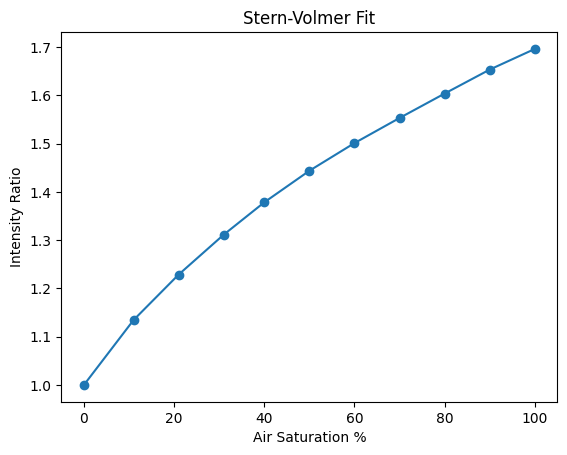

In [5]:
# Create a plot
plt.plot(grouped_data.index, grouped_data['Intensity Ratio'], 'o-')

# Set the x-axis and y-axis labels
plt.title('Stern-Volmer Fit')
plt.xlabel('Air Saturation %')
plt.ylabel('Intensity Ratio')
plt.show()

In [6]:
# define simplified Stern-Volmer function
def _sternvolmer_simple(x, f, k):
    """
    fitting function according to the common two site model. In general, x represents the pO2 or pCO2 content, whereas
    m, k and f are the common fitting parameters
    :param x:   list
    :param k:   np.float
    :param f:   np.float
    :return:
    """
    # R0/R
    int_ratio = 1 / (f / (1. + k*x) + (1.-f))
    return int_ratio

# make your function a model to be used by lmfit
simple_sv = Model(_sternvolmer_simple)

In [7]:
# set initial parameter
params_sens = simple_sv.make_params(k=0.165, f=0.887) # from previous calibrations approximately known
params_sens['k'].min = 0.
params_sens['f'].max = 1.

# use R0/R data for fit and re-calculate i afterwards
# full concentration range
ytofit_sens = grouped_data['Intensity Ratio'].to_numpy()
xtofit_sens = grouped_data.index.to_numpy() 
result = simple_sv.fit(ytofit_sens, params_sens, x=xtofit_sens, nan_policy='omit')

[[Model]]
    Model(_sternvolmer_simple)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 3
    # data points      = 11
    # variables        = 1
    chi-square         = 1.7476e-04
    reduced chi-square = 1.7476e-05
    Akaike info crit   = -119.549990
    Bayesian info crit = -119.152094
    R-squared          = 0.99964817
[[Variables]]
    f:  0.60571155 +/- 0.00105545 (0.17%) (init = 0.6057115)
    k:  0.02071655 (fixed)


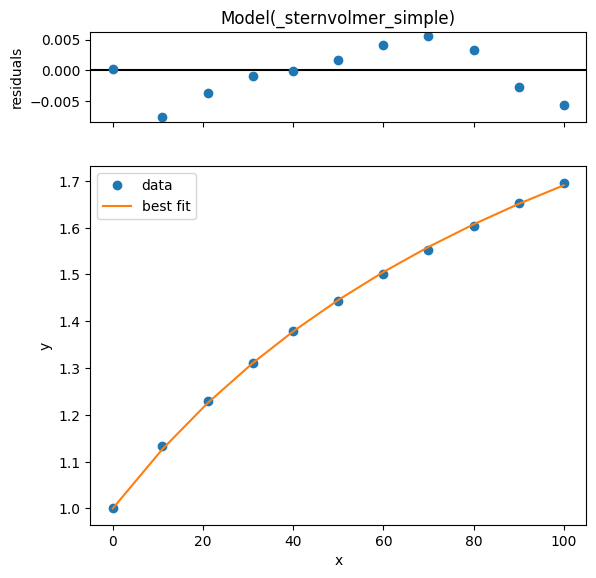

In [9]:
# to optimize the fit (and be sure of the parameter) >> 2nd round with one parameter fixed
params_sens2 = params_sens.copy()
params_sens2['k'].value = result.best_values['k']
params_sens2['k'].vary = False
params_sens2['f'].value = result.best_values['f']

params_sens2['f'].min = 0.
params_sens2['f'].max = 1.
result2 = simple_sv.fit(ytofit_sens, params_sens2, x=xtofit_sens, nan_policy='omit')

df_bestFit_preSens_norm = pd.DataFrame(1 / result2.best_fit, index=xtofit_sens)
df_bestFit_preSens = pd.DataFrame(grouped_data.loc[0, 'Intensity Ratio'] / result2.best_fit, index=xtofit_sens)
result2.best_values
fit_report = result2.fit_report()
print(fit_report)
result2.plot()
plt.show()



In [ ]:
# SAVE THE RESULT
# best fit for parameter done... save report
import datetime

now = datetime.datetime.now()
time_now = now.strftime('%Y%m%d-%H%M%S')

# save fit report to a file
with open('C:/Users/au519867/OneDrive - Aarhus universitet/Skrivebord/Raw_Images/RAW_Stacks/Intensity_Ratio/' + time_now + '_fit_result.txt', 'w') as fh:
    fh.write(fit_report)
